# TUTORIAL NMMA- Light curve simulation

In [19]:
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import copy
import scipy
import nmma.em.io as io
from nmma.em.model import SimpleKilonovaLightCurveModel,GRBLightCurveModel, SVDLightCurveModel, KilonovaGRBLightCurveModel, CombinedLightCurveModelContainer
from nmma.em import training, utils, model_parameters
from sncosmo.bandpasses import _BANDPASSES

In [20]:
import afterglowpy as grb

In [21]:
Z = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
     'specType':    0,                  # Basic Synchrotron Emission Spectrum

     'thetaObs':    0.05,   # Viewing angle in radians
     'E0':          1.0e53, # Isotropic-equivalent energy in erg
     'thetaCore':   0.1,    # Half-opening angle in radians
     'n0':          1.0,    # circumburst density in cm^{-3}
     'p':           2.2,    # electron energy distribution index
     'epsilon_e':   0.1,    # epsilon_e
     'epsilon_B':   0.01,   # epsilon_B
     'xi_N':        1.0,    # Fraction of electrons accelerated
     'd_L':         1.0e28, # Luminosity distance in cm
     'z':           0.55}   # redshift


In [22]:
t = np.geomspace(1.0e3, 1.0e7, 300)

# Calculate flux in a single X-ray band (all times have same frequency)
nu = np.empty(t.shape)
nu[:] = 1.0e18

# Calculate!

Fnu = grb.fluxDensity(t, nu, **Z)


The package nmma.em.model contains a number of models can be used to perform a simulation, some of them use parametric models derived from data: SVDLightCurveModel; others use parametrized models from the letterature: SimpleKilonovaLightCurveModel, GRBLightCurveModel, KilonovaGRBLightCurveModel, CombinedLightCurveModelContainer. 

In the following for each of the model the parameters the function has to be injected with to run the simulation.

In [23]:
import nmma
nmma.em.model.model_parameters_dict

{'Arnett': ['tau_m', 'log10_mni'],
 'Arnett_modified': ['tau_m', 'log10_mni', 't_0'],
 'Bu2019nsbh': ['log10_mej_dyn', 'log10_mej_wind', 'KNtheta'],
 'Bu2019lm': ['log10_mej_dyn', 'log10_mej_wind', 'KNphi', 'KNtheta'],
 'Bu2019lm_sparse': ['log10_mej_dyn', 'log10_mej_wind'],
 'Ka2017': ['log10_mej', 'log10_vej', 'log10_Xlan'],
 'TrPi2018': ['inclination_EM',
  'log10_E0',
  'thetaCore',
  'thetaWing',
  'b',
  'L0',
  'q',
  'ts',
  'log10_n0',
  'p',
  'log10_epsilon_e',
  'log10_epsilon_B',
  'xi_N',
  'd_L'],
 'Piro2021': ['log10_Menv', 'log10_Renv', 'log10_Ee'],
 'Me2017': ['log10_mej', 'log10_vej', 'beta', 'log10_kappa_r'],
 'Bu2022mv': ['log10_mej_dyn',
  'vej_dyn',
  'log10_mej_wind',
  'vej_wind',
  'KNtheta'],
 'PL_BB_fixedT': ['bb_luminosity', 'temperature', 'beta', 'powerlaw_mag'],
 'blackbody_fixedT': ['bb_luminosity', 'temperature'],
 'synchrotron_powerlaw': ['alpha_time',
  'beta_freq',
  'F_ref',
  'luminosity_distance'],
 'CV': ['example_num'],
 'AnBa2022_sparse': ['mrp

**All the lightcurves will be simulated in the following filters:**

In [24]:
sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}
sncosmo_maps

{'bessellux': 'bessellux',
 'bessellb': 'bessellb',
 'bessellv': 'bessellv',
 'bessellr': 'bessellr',
 'besselli': 'besselli',
 'standard::u': 'standard__u',
 'standard::b': 'standard__b',
 'standard::v': 'standard__v',
 'standard::r': 'standard__r',
 'standard::i': 'standard__i',
 'desu': 'desu',
 'desg': 'desg',
 'desr': 'desr',
 'desi': 'desi',
 'desz': 'desz',
 'desy': 'desy',
 'sdssu': 'sdssu',
 'sdssg': 'sdssg',
 'sdssr': 'sdssr',
 'sdssi': 'sdssi',
 'sdssz': 'sdssz',
 'f435w': 'f435w',
 'f475w': 'f475w',
 'f555w': 'f555w',
 'f606w': 'f606w',
 'f625w': 'f625w',
 'f775w': 'f775w',
 'f850lp': 'f850lp',
 'nicf110w': 'nicf110w',
 'nicf160w': 'nicf160w',
 'f098m': 'f098m',
 'f105w': 'f105w',
 'f110w': 'f110w',
 'f125w': 'f125w',
 'f127m': 'f127m',
 'f139m': 'f139m',
 'f140w': 'f140w',
 'f153m': 'f153m',
 'f160w': 'f160w',
 'f218w': 'f218w',
 'f225w': 'f225w',
 'f275w': 'f275w',
 'f300x': 'f300x',
 'f336w': 'f336w',
 'f350lp': 'f350lp',
 'f390w': 'f390w',
 'f689m': 'f689m',
 'f763m': '

To use the model what is needed is a two step process:

1- create the object with the model 

2- inject the parameters

The result is the absolute magnitude lightcurve in all the filters.

**Note: sample_times is an array which represent the time from the explosion, do not use MJD!**

In [25]:
# create the object
tmin, tmax, dt = 0.5, 20.0, 0.1
sample_times = np.arange(tmin, tmax + dt, dt)
colors = {'sdssu':'purple','ztfg':'blue','ztfr':'forestgreen','ztfi':'gold','ps1__z':'orange','ps1__y':'red'}

kn_model = SimpleKilonovaLightCurveModel(filters=colors.keys())

# run the simulation
bestfit_params = {
    "luminosity_distance": 350,
    "beta": 3.6941470839046575,
    "log10_kappa_r": 0.98,
    "timeshift": 0.183516607107672,
    "log10_vej": -0.48,
    "log10_mej": -0.52,
}
_, mag_kn = kn_model.generate_lightcurve(sample_times, bestfit_params)

In [26]:
param={"luminosity_distance": 350,
        "Ebv": 0.0,
        'jetType':0,
        "inclination_EM":0,
        "log10_E0": 50.,
        "thetaCore": 0.1,
        "thetaWing": 0.1,
        "log10_n0": -1,
        'p':           2.2,    # electron energy distribution index
        "log10_epsilon_e":   -1,    # epsilon_e
        "log10_epsilon_B":   -2,   # epsilon_B
        'xi_N':        1.0}
grb_model = GRBLightCurveModel(filters=colors.keys())
_, mag_grb = grb_model.generate_lightcurve(sample_times, param)

In [27]:
from scipy.special import logsumexp
total_mag={}
for f in mag_kn:
    total_mag[f] = (
        -5.0
        / 2.0
        * logsumexp(
            [-2.0 / 5.0 * np.log(10) * mag_grb[f], -2.0 / 5.0 * np.log(10) * mag_kn[f]],
            axis=0,
        )/ np.log(10))

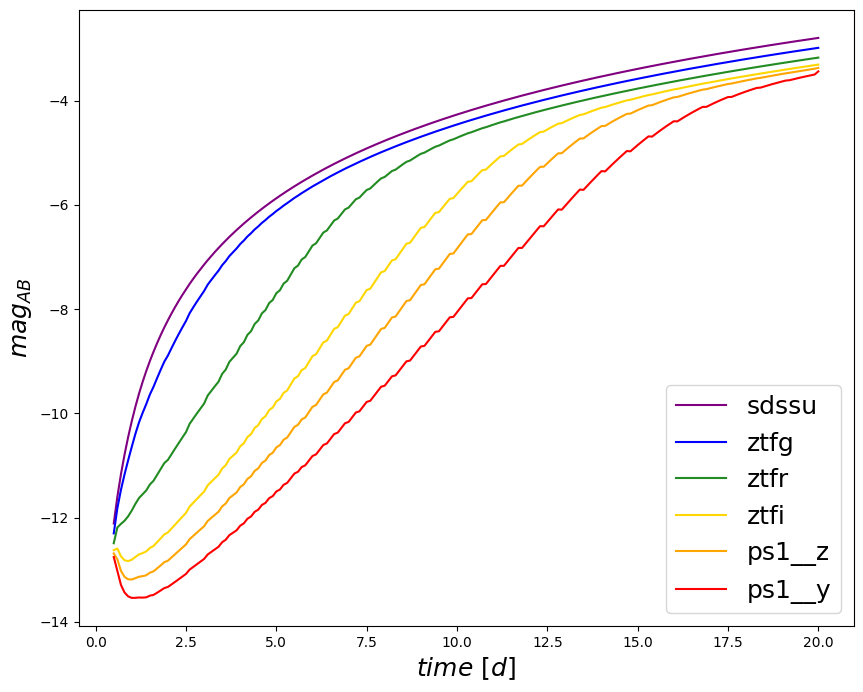

In [28]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(1,1,figsize=(10,8))
for f in colors.keys():
    m = total_mag[f]
    #merr = np.array(lcs['merr'])[mask][ind]
    ax.plot(sample_times, m,'-', label=f,color=colors[f])
    ax.set_ylabel(r'$mag_{AB}$', fontsize=18)
    ax.set_xlabel(r'$time~[d]$', fontsize=18)
    ax.ticklabel_format(useOffset=False)
    #ax.set_xscale('log')
ax.legend(fontsize=18)
plt.show()

If you want to simulate data from a specific data set you might want to run a features extraction on your data and insert these as a *new model* in the list of model in nmma.em.model

The procedure to do that is described in the following:

    1- create the files with the features and  and the parameters for the gaussian process
    2- create the light curve model for the subsequent simulations

The modelname is related to a funciton to extract the parameter we need from the data. Helper function are in model_parameter module already, so to run an example I will refer to one of those (be aware that errors can rise if the fuction is not the right one to process the data):

In [29]:
model_name = "Bu2019lm"
n_coeff = 3
# The array of times we'll use to examine each lightcurve
tini, tmax, dt = 0.1, 5.0, 0.2
tt = np.arange(tini, tmax + dt, dt)  

# The filters we'll be focusing on
filts = ["sdssu","ztfg","ztfr","ztfi","ps1__z","ps1__y","2massj","2massh","2massks"] # We will focus on these two bands; all available: ["u","g","r","i","z","y","J","H","K"]
#filts = ["u","g","r","i","z","y","J","H","K"]

print(os.getcwd())
dataDir = "../nmma/tests/data/bulla" ## Example absolute path: "/Users/fabioragosta/nmma/nmma/tests/data/bulla"
ModelPath = "../svdmodels" ## Example absolute path: "/Users/fabioragosta/nmma/svdmodels"
filenames = glob.glob("%s/*.dat" % dataDir)

data = io.read_photometry_files(filenames, filters=filts)
# Loads the model data
training_data, parameters = model_parameters.Bu2019lm_sparse(data)

#two differen interpolation types are possible "sklearn_gp" or "tensorflow"
interpolation_type = "sklearn_gp"
training_model=training.SVDTrainingModel(
    model_name,
    copy.deepcopy(training_data),
    parameters,
    tt,
    filts,
    svd_path=ModelPath,
    n_coeff=n_coeff,
    interpolation_type=interpolation_type,
    n_epochs=100
)

light_curve_model = SVDLightCurveModel(
        model_name,
        svd_path=ModelPath,
        interpolation_type=interpolation_type,
        model_parameters=training_model.model_parameters,
        filters=filts,
    )

/home/hrose/Dokumente/40_nuclear/01_eos_dev/11_git_version/nmma/tutorials
The grid will be interpolated to sample_time with linear interpolation
Model exists... will load that model.
Load filter sdssu
Load filter ztfg
Load filter ztfr
Load filter ztfi
Load filter ps1__z
Load filter ps1__y
Load filter 2massj
Load filter 2massh
Load filter 2massks


using the model we derived with the SVD training we could recostruct the lightcurves and retrieve the parameters 

In [30]:
modelkeys = list(training_data.keys())
for mk in modelkeys:
    training_ = training_data[mk]
    parameters = training_model.model_parameters
    data = {param: training_[param] for param in parameters}
    print(data)

{'log10_mej_dyn': -3.0, 'log10_mej_wind': -2.0}
{'log10_mej_dyn': -3.0, 'log10_mej_wind': -1.154901959985743}
{'log10_mej_dyn': -2.3010299956639813, 'log10_mej_wind': -1.5228787452803376}
{'log10_mej_dyn': -1.6989700043360187, 'log10_mej_wind': -0.958607314841775}
{'log10_mej_dyn': -2.3010299956639813, 'log10_mej_wind': -1.3010299956639813}
{'log10_mej_dyn': -3.0, 'log10_mej_wind': -0.958607314841775}
{'log10_mej_dyn': -3.0, 'log10_mej_wind': -1.3010299956639813}
{'log10_mej_dyn': -2.0, 'log10_mej_wind': -1.154901959985743}
{'log10_mej_dyn': -2.0, 'log10_mej_wind': -0.958607314841775}
{'log10_mej_dyn': -3.0, 'log10_mej_wind': -0.8860566476931632}
{'log10_mej_dyn': -1.6989700043360187, 'log10_mej_wind': -1.3010299956639813}
{'log10_mej_dyn': -2.0, 'log10_mej_wind': -1.5228787452803376}
{'log10_mej_dyn': -3.0, 'log10_mej_wind': -1.5228787452803376}
{'log10_mej_dyn': -2.0, 'log10_mej_wind': -0.8860566476931632}
{'log10_mej_dyn': -2.3010299956639813, 'log10_mej_wind': -2.0}
{'log10_mej_dyn

/tmp/ipykernel_38107/1685388672.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


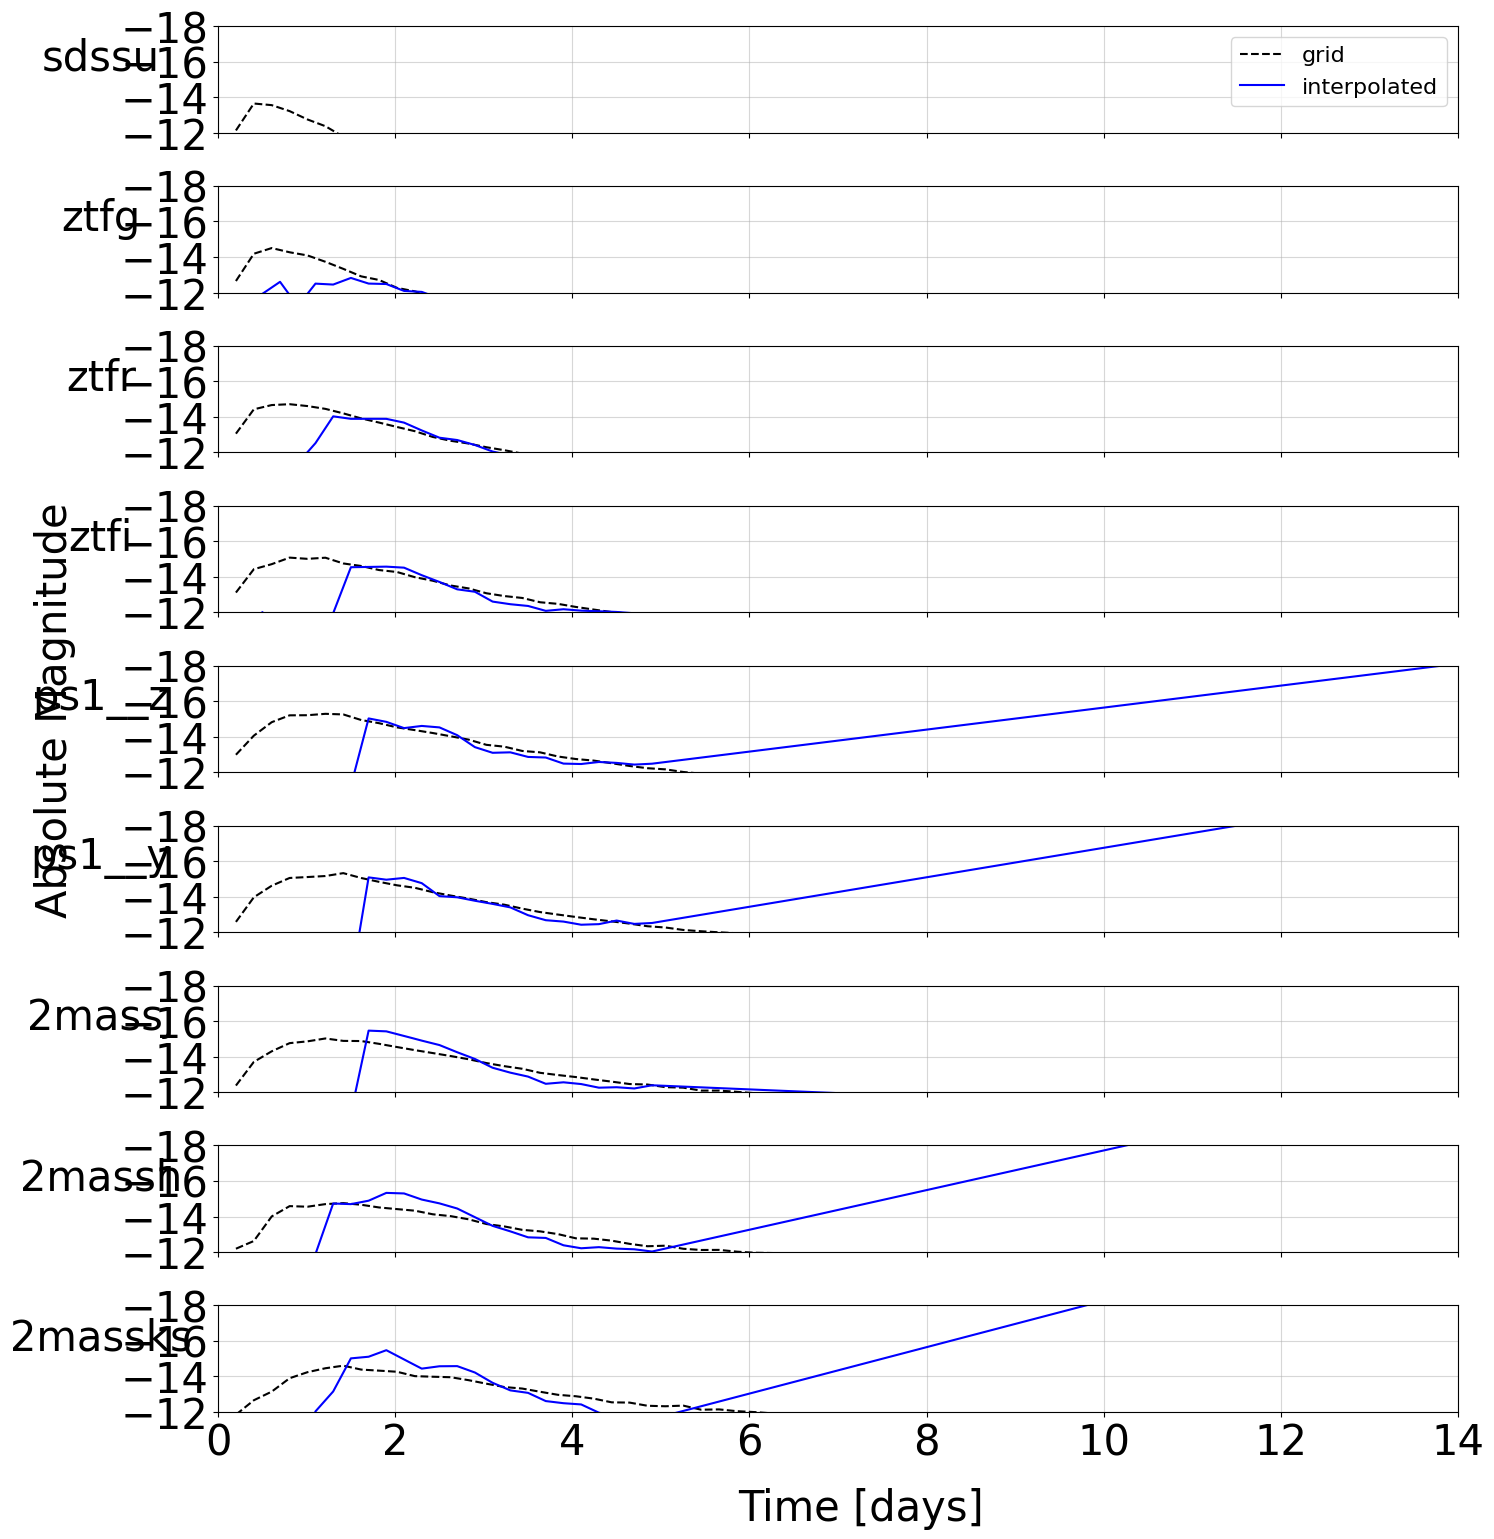

In [31]:
modelkeys = list(training_data.keys())
training = training_data[modelkeys[0]]
parameters = training_model.model_parameters
data = {param: training[param] for param in parameters}
data["redshift"] = 0
data['inclination_EM']=0
lbol, mag = light_curve_model.generate_lightcurve(sample_times, data)

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 18))

ncols = 1
nrows = int(np.ceil(len(filts) / ncols))
gs = fig.add_gridspec(nrows=nrows, ncols=ncols, wspace=0.6, hspace=0.5)

for ii, filt in enumerate(filts):
    loc_x, loc_y = np.divmod(ii, nrows)
    loc_x, loc_y = int(loc_x), int(loc_y)
    ax = fig.add_subplot(gs[loc_y, loc_x])

    plt.plot(training['t'], training[filt], "k--", label="grid")
    plt.plot(sample_times, mag[filt], "b-", label="interpolated")

    ax.set_xlim([0, 14])
    ax.set_ylim([-12, -18])
    ax.set_ylabel(filt, fontsize=30, rotation=0, labelpad=14)

    if ii == 0:
        ax.legend(fontsize=16)

    if ii == len(filts) - 1:
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_yticks([-18, -16, -14, -12])
    ax.tick_params(axis="x", labelsize=30)
    ax.tick_params(axis="y", labelsize=30)
    ax.grid(which="both", alpha=0.5)

fig.text(0.45, 0.05, "Time [days]", fontsize=30)
fig.text(
    0.01,
    0.5,
    "Absolute Magnitude",
    va="center",
    rotation="vertical",
    fontsize=30,
)

plt.tight_layout()
plt.show()

to simulate a new lc we need to pass to the lightcurve model a different set of parameters

In [32]:
tmin, tmax, dt = 0.5, 20.0, 0.5
sample_times = np.arange(tmin, tmax + dt, dt)
param= {'log10_mej_dyn': -1.0, 'log10_mej_wind': -3.0457574905606752, 'redshift':0.4, 'inclination_EM':0}

_, mag = light_curve_model.generate_lightcurve(sample_times,parameters=param)


In [33]:
pd.DataFrame(mag).head()

,sdssu,ztfg,ztfr,ztfi,ps1__z,ps1__y,2massj,2massh,2massks
0,-8.011435,-6.012311,-4.301125,-6.235350,-4.945571,-3.919255,-4.441560,-6.213158,-4.743436
1,-6.814922,-7.589514,-5.863432,-7.288472,-5.866744,-5.736082,-5.808243,-6.849492,-7.439033
2,-6.253190,-7.023830,-6.345669,-6.261570,-5.960169,-5.319173,-6.563952,-8.247048,-8.584500
3,-6.954874,-7.305238,-7.317975,-7.799798,-6.212085,-5.692949,-6.390887,-9.812025,-9.301728
4,-6.591425,-7.173250,-7.423352,-7.971744,-8.451033,-8.530182,-8.433499,-8.790100,-8.742496


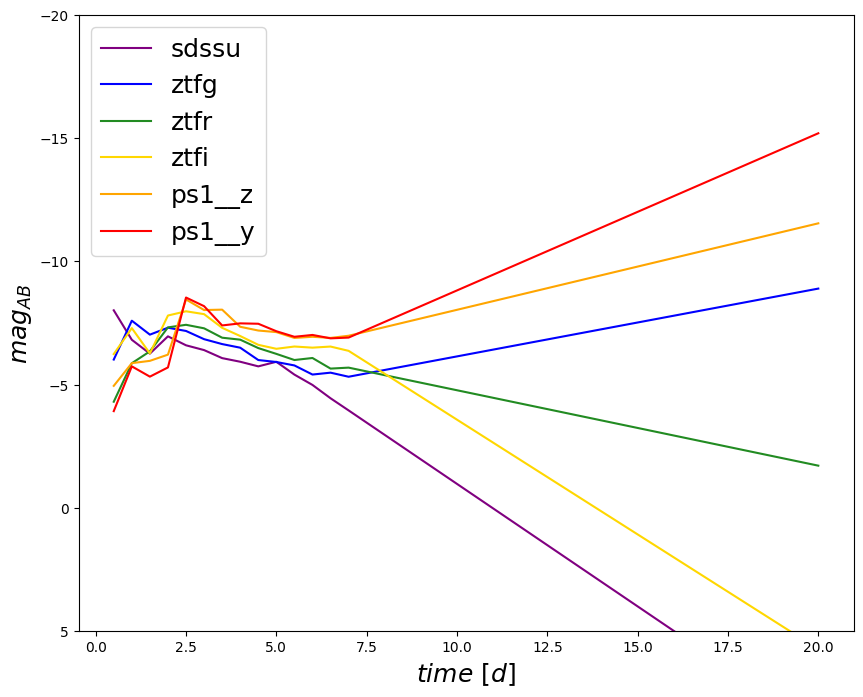

In [34]:
colors = {'sdssu':'purple','ztfg':'blue','ztfr':'forestgreen','ztfi':'gold','ps1__z':'orange','ps1__y':'red'}
fig, ax = plt.subplots(1,1,figsize=(10,8))
for f in colors.keys():
    m = np.array(mag[f])
    #merr = np.array(lcs['merr'])[mask][ind]
    ax.plot(sample_times, m,'-', label=f,color=colors[f])
    ax.set_ylabel(r'$mag_{AB}$', fontsize=18)
    ax.set_xlabel(r'$time~[d]$', fontsize=18)
    ax.ticklabel_format(useOffset=False)
    #ax.set_xscale('log')
    ax.set_ylim([5,-20])
    ax.legend(fontsize=18)
plt.show()

Eventually you might want to combine different lightcurve models, you can do this using CombinedLightCurveModelContainer, all you need is a list of light curve models.

In the example I use the light curve models I have created in this notebook.

In [35]:
models = [light_curve_model,kn_model]
combine_lc = CombinedLightCurveModelContainer(models=models)
param_combine={}
param_combine.update(param)
param_combine.update(bestfit_params)
_, mag =combine_lc.generate_lightcurve(sample_times, param_combine)

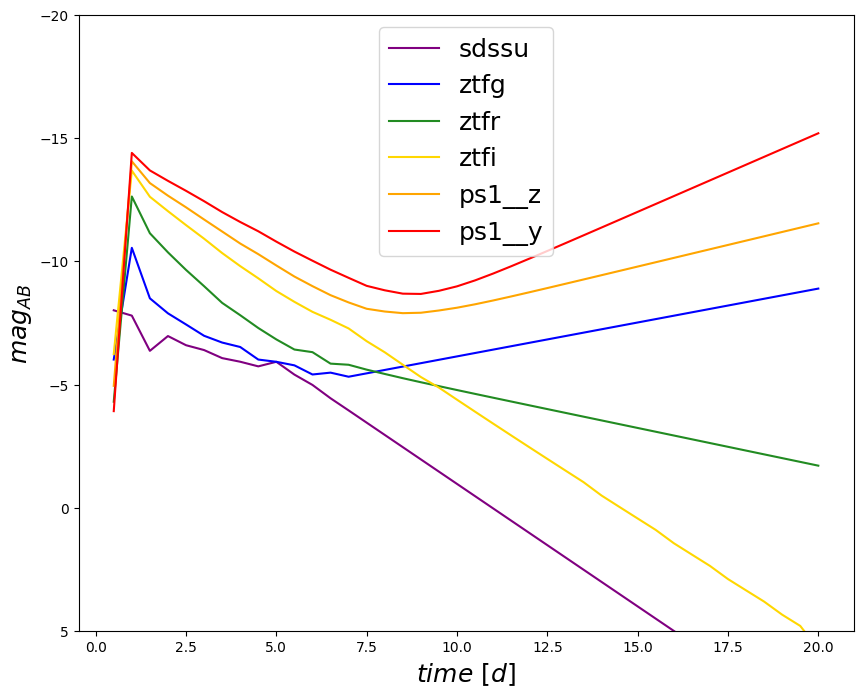

In [36]:
colors = {'sdssu':'purple','ztfg':'blue','ztfr':'forestgreen','ztfi':'gold','ps1__z':'orange','ps1__y':'red'}
fig, ax = plt.subplots(1,1,figsize=(10,8))
for f in colors.keys():
    m = np.array(mag[f])
    #merr = np.array(lcs['merr'])[mask][ind]
    ax.plot(sample_times, m,'-', label=f,color=colors[f])
    ax.set_ylabel(r'$mag_{AB}$', fontsize=18)
    ax.set_xlabel(r'$time~[d]$', fontsize=18)
    ax.ticklabel_format(useOffset=False)
    #ax.set_xscale('log')
    ax.set_ylim([5,-20])
    ax.legend(fontsize=18)
plt.show()